In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import geopandas as gpd
import descartes

In [2]:
datasets = ['consolidated_legend.csv', 'drug_spending.csv', 'expenditure_by_type.csv', 'national_spending_by_sector.csv', 
 'private_expenditure.csv', 'provincial_level.csv', 'services_expenditure.csv']

In [3]:
for path in datasets:
    globals()[path[:-4]] = pd.read_csv('data/canada_data/' + path)

In [4]:
def clean_and_save_changes():
    regex = "(Quebec)|(Nova Scotia)|(Alberta)|(Newfoundland and Labrador)|(Prince Edward Island)|(Saskatchewan)|(Northwest Territories)|(New Brunswick)|(Nunavut)|(British Columbia)|(Manitoba)|(Yukon)|(Ontario)|(North West Territories)"
    df = consolidated_legend['Legend'].str.extract(regex)
    col = df.assign(D=df.lookup(df.index, df.isnull().idxmin(1)))['D']
    consolidated_legend['Province'] = col.str.replace('North West', 'Northwest')
    mapper = {'Quebec': 'Que.', 
              'Nova Scotia': 'N.S.', 
              'Alberta': 'Alta.',
              'Newfoundland and Labrador': 'N.L.', 
              'Prince Edward Island': 'P.E.I.',
              'Saskatchewan': 'Sask.', 
              'Northwest Territories': 'N.W.T.',
              'New Brunswick': 'N.B.', 
              'Nunavut': 'Nun.', 
              'British Columbia': 'B.C.', 
              'Manitoba': 'Man.',
              'Yukon': 'Y.T.', 
              'Ontario': 'Ont.'}
    consolidated_legend['Province Code'] = consolidated_legend['Province'].map(mapper)
    consolidated_legend.to_csv('data/canada_data/consolidated_legend.csv', index=False)

    drug_spending['Shorthand'] = drug_spending['Category'].str.extract('(.*(?=:))')
    drug_spending = pd.merge(drug_spending, consolidated_legend, on='Shorthand').drop(columns=['Location'])
    drug_spending.to_csv('data/canada_data/drug_spending.csv', index=False)

    expenditure_by_type['Shorthand'] = expenditure_by_type['Category'].str.extract('(.*(?=:))')
    expenditure_by_type = pd.merge(expenditure_by_type, consolidated_legend, on='Shorthand').drop(columns=['Location'])
    expenditure_by_type.to_csv('data/canada_data/expenditure_by_type.csv', index=False)

    provincial_level['Shorthand'] = provincial_level['Category'].str.extract('(.*(?=:))')
    provincial_level = provincial_level.rename(columns={'Alta.  ':'Alta.', 'N.B. ':'N.B.', 'Man. ':'Man.', 'B.C. ':'B.C.'})
    provincial_level.to_csv('data/canada_data/provincial_level.csv')
    
# clean_and_save_changes()

In [5]:
# Build master dataset
#

cols = ['N.L.', 'P.E.I.', 'N.S.', 'N.B.','Que.', 'Ont.', 'Man.', 'Sask.', 'Alta.', 'B.C.', 'Y.T.', 'N.W.T.', 'Nun.']

# Private spending by type total
private_total = [f'D.2.{i}.1' for i in range(1, 14)]

# Private spending by type per capita
private_capita = [f'D.2.{i}.3' for i in range(1, 14)]

# Public spending by type total
public_total = [f'D.3.{i}.1' for i in range(1, 14)]

# Public spending by type per capita
public_capita = [f'D.3.{i}.3' for i in range(1, 14)]


def extract_feature(feature_key, name):
    return pd.melt(provincial_level[provincial_level['Shorthand'] == feature_key], 
                   id_vars=['Year'], value_vars=cols, 
                   var_name='Province Code', value_name=name)

def extract_expenditure(key_list, exp_type, name):
    result = expenditure_by_type[expenditure_by_type['Shorthand'].isin(key_list)]
    result = result[['Year', 'Province Code', exp_type]]
    result[exp_type] = result[exp_type].astype(float)
    result = result.rename(columns={exp_type:name})
    return result

def build_dataset():
    df = extract_feature('Appendix: A.1', 'GDP ($mm)')
    df = pd.merge(df, extract_feature('Appendix: D.1', 'Pop (k)'), on=['Year', 'Province Code'])
    df['GDP/capita ($)'] = (df['GDP ($mm)'] * 1000000) / (df['Pop (k)'] * 1000)
    df = pd.merge(df, extract_feature('Appendix: B.2', 'CPI (healthcare)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_feature('B.2.2', 'Private health spend/capita ($)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_feature('B.2.1', 'Private health spend total ($mm)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_feature('B.3.2', 'Public health spend/capita ($)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_feature('B.3.1', 'Public health spend total ($mm)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_expenditure(private_capita, 'Drugs', 'Private drug spend/capita ($)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_expenditure(private_total, 'Drugs', 'Private drug spend total ($mm)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_expenditure(public_capita, 'Drugs', 'Public drug spend/capita ($)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_expenditure(public_total, 'Drugs', 'Public drug spend total ($mm)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_expenditure(private_capita, 'Hospitals', 'Private hospital spend/capita ($)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_expenditure(private_total, 'Hospitals', 'Private hospital spend total ($mm)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_expenditure(public_capita, 'Hospitals', 'Public hospital spend/capita ($)'), on=['Year', 'Province Code'])
    df = pd.merge(df, extract_expenditure(public_total, 'Hospitals', 'Public hospital spend total ($mm)'), on=['Year', 'Province Code'])

    lst = [f'Appendix: D.{i}: Population by age: both sexes' for i in range(3, 23)]
    p = provincial_level[provincial_level['Category'].isin(lst)].copy()
    p = p[p['Age Groups'] != 'All']
    p['Working Age'] = ~p['Age Groups'].isin(['1-4', '<1', '5-9', '10-14', '15-19', '65-69', '70-74', '75-79', '80-84', '85-89', '90+'])
    p = p.groupby(['Working Age', 'Year']).sum().reset_index()
    non_working = pd.melt(p[p['Working Age'] == False], id_vars=['Year'], value_vars=cols, 
            var_name='Province Code', value_name='Non-working age pop (k)')
    working = pd.melt(p[p['Working Age'] == True], id_vars=['Year'], value_vars=cols, 
            var_name='Province Code', value_name='Working age pop (k)')
    df = pd.merge(df, non_working, on=['Year', 'Province Code'], how='left')
    df = pd.merge(df, working, on=['Year', 'Province Code'], how='left')
    df['Pct working age (%)'] = df['Working age pop (k)'] / df['Pop (k)'] * 100
    return df

data = build_dataset()
data.to_csv('data/canada_data/master_data.csv')

/Users/shaw/.virtualenvs/school/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                                    OLS Regression Results                                   
Dep. Variable:     Private hospital spend/capita ($)   R-squared:                       0.564
Model:                                           OLS   Adj. R-squared:                  0.513
Method:                                Least Squares   F-statistic:                     10.99
Date:                               Sat, 27 Jul 2019   Prob (F-statistic):           0.000863
Time:                                       15:17:11   Log-Likelihood:                -74.967
No. Observations:                                 20   AIC:                             155.9
Df Residuals:                                     17   BIC:                             158.9
Df Model:                                          2                                         
Covariance Type:                           nonrobust                                         
                          coef    std err          t      P>

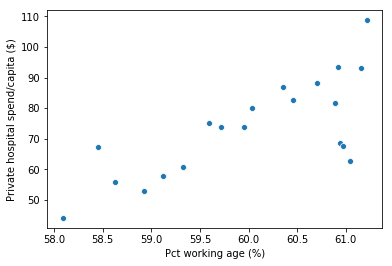

In [6]:
province = 'P.E.I.'
target = 'Private hospital spend/capita ($)'
features = ['Pct working age (%)', 'GDP/capita ($)']

result = sm.OLS(data[data['Province Code'] == province][target], 
                sm.add_constant(data[data['Province Code'] == province][features]), missing='drop').fit()
print(result.summary())
sns.scatterplot(features[0], target, data=data[data['Province Code'] == province]);
# sns.regplot(features[0], target, hue='Province Code', data=df)

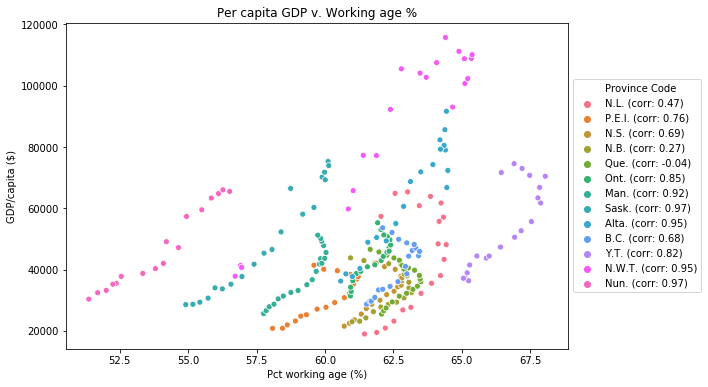

In [7]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.scatterplot('Pct working age (%)', 'GDP/capita ($)', hue='Province Code',data=data, ax=ax)
leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Per capita GDP v. Working age %')
for text in leg.get_texts():
    prov = text.get_text()
    if prov != 'Province Code':
        mask = data['Province Code'] == prov
        prov_df = data[mask][['Pct working age (%)', 'GDP/capita ($)']]
        text.set_text(prov + f' (corr: {round(prov_df.corr().iloc[1,0], 2)})')

In [8]:
map_path = r'data/canada_mapdata/lpr_000b16a_e.shp'
map_df = gpd.read_file(map_path)
map_df.head()

,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
0,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,"(POLYGON ((8307365.58857 2582136.71143, 830839..."
1,11,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,"(POLYGON ((8435711.754285 1679935.965715, 8435..."
2,12,Nova Scotia / Nouvelle-Écosse,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,"(POLYGON ((8470851.645715 1624745.01143, 84710..."
3,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"(POLYGON ((8176224.537145 1722553.46, 8176230...."
4,24,Quebec / Québec,Quebec,Québec,Que.,Qc,"(POLYGON ((8399709.494284999 2261445.702855, 8..."


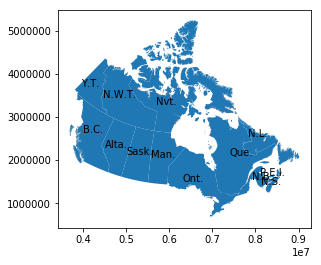

In [9]:
map_df['labels'] = map_df['geometry'].apply(lambda x: x.representative_point().coords[:])
map_df['labels'] = [labels[0] for labels in map_df['labels']]

map_df.plot()
for idx, row in map_df.iterrows():
    plt.annotate(s=row['PREABBR'], xy=row['labels'],
                 horizontalalignment='center')